In [1]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED
include("../Landau level triangular.jl")
using .LLT

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum(subtitle=nothing)
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
    )
    ax_top = Axis(fig[1, 1];
        xlabel = "momentum block number",
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(subspaces)
        x = Gk[2] * ss_k1[i] + ss_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        for e in energies[i]
            scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
        end
    end
    ax_top.xticks = top_ticks
    if subtitle isa String
        ax_top.subtitle = subtitle
    end
    display(fig)
end

plot_ed_spectrum (generic function with 2 methods)

In [78]:
# Define k-mesh for bilayer system (4×3 mesh, Nk=12) in triangular lattice
k_list = [0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2]
Nk = 12
Gk = (4, 3)  # Grid dimensions

# number of electrons in each layer
Ne1 = 6
Ne2 = 6

# Number of layers (components) for bilayer system
Nc_conserve = 2

2

In [79]:
# Set up one-body Hamiltonian matrix for inter-layer tunneling
ΔE = 0.0 * LLT.W0                # Energy difference between the two layers

# H_onebody[c1, c2, cc, k] : no hopping from component c2 to c1
# For bilayer system: Nc_hopping=1, Nc_conserve=2, No tunneling
H_onebody_bilayer_no_tunneling = zeros(ComplexF64, 1, 1, Nc_conserve, Nk)
for k_idx in 1:Nk
    H_onebody_bilayer_no_tunneling[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer_no_tunneling[1, 1, 2, k_idx] = -0.5ΔE
end

# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction(
    (1, 0, 1, 0),
    (2, 0, 1, 0)
);

In [80]:
# Interaction parameters

# Coulomb
sys_int.D_l = 10.0                  # Screening length D/l
sys_int.d_l = 1                  # Inter-layer distance d/l
# compute the pseudo-potential components
intra_PP = LLT.pseudo_potential_decomposition.(0:15; same_layer = true,  D_l = sys_int.D_l, d_l = sys_int.d_l)
inter_PP = LLT.pseudo_potential_decomposition.(0:15; same_layer = false, D_l = sys_int.D_l, d_l = sys_int.d_l)
@show intra_PP
@show inter_PP

# Haldane pseudo-potential
# sys_int.V_intra = [0.0; 0.8; 0.0; 0.4]          # Intralayer Haldane pseudo-potential in unit of W0
# sys_int.V_inter = [1.5; 0.7; 0.5; 0.4]          # Interlayer Haldane pseudo-potential in unit of W0

# or use Coulomb interaction with a cutoff in m
sys_int.V_intra = copy(intra_PP)
sys_int.V_inter = copy(inter_PP)

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 0                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para_conserve = EDPara(
    k_list = k_list, 
    Gk = Gk, 
    Nc_hopping = 1,
    Nc_conserve = Nc_conserve,
    H_onebody = H_onebody_bilayer_no_tunneling,
    V_int = sys_int,
    FF_inf_angle = LLT.Landau_ff_inf(sys_int),
);

intra_PP = [1.6341991947102161, 0.7488598133546632, 0.5281765904875219, 0.41825804439856695, 0.34986803155496876, 0.30223593222762896, 0.266707499725575, 0.23895575700640043, 0.21654690215344488, 0.19799371629995444, 0.18232959739735166, 0.16889557727263255, 0.15722495601745753, 0.1469767450351728, 0.13789525757632415, 0.12978451617834638]
inter_PP = [0.9536152926614218, 0.636026219573564, 0.4834882387026461, 0.39388037090686623, 0.33424593599922947, 0.2912399244753895, 0.2584849301718478, 0.2325435446759757, 0.21139046639862796, 0.19374888446058133, 0.17877024474768707, 0.16586632894961464, 0.1546151243228702, 0.14470509884006003, 0.13590068254099996, 0.1280200523723819]


In [81]:
NG = 2
index_shift = NG .* Gk .+ 1
densities = MBOperator[density_operator(q1, q2, lf, li; 
        para = para_conserve, form_factor = true)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2], lf = 1:2, li=1:2
];
function structure_factor_expectation(myvec)
    structure_factor = similar(densities, ComplexF64)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2]
        for lf = 1:2, li = 1:2
            structure_factor[index_shift[1]+q1, index_shift[2]+q2, lf, li] = 
                ED_bracket_threaded(myvec, 
                    densities[index_shift[1]-q1, index_shift[2]-q2, li, lf], 
                    densities[index_shift[1]+q1, index_shift[2]+q2, lf, li], myvec
                )
            if mod(q1, Gk[1]) == 0 && mod(q2, Gk[2])== 0 && lf==li
                structure_factor[index_shift[1]+q1, index_shift[2]+q2, lf, li] -= 
                    ED_bracket(myvec, densities[index_shift[1]-q1, index_shift[2]-q2, li, lf], myvec) * 
                    ED_bracket(myvec, densities[index_shift[1]+q1, index_shift[2]+q2, lf, li], myvec)
            end
        end
    end
    structure_factor ./= Nk
end

structure_factor_expectation (generic function with 1 method)

In [82]:
# Create momentum blocks for bilayer system
subspaces, ss_k1, ss_k2 = 
    ED_momentum_subspaces(para_conserve, (Ne1, Ne2));
display(length.(subspaces))

# Generate Scatter lists for efficient Hamiltonian construction
scat_list1_conserve = ED_sortedScatterList_onebody(para_conserve);
scat_list2_conserve = ED_sortedScatterList_twobody(para_conserve);

12-element Vector{Int64}:
 71188
 71178
 71178
 71120
 71112
 71112
 71188
 71178
 71178
 71120
 71112
 71112

In [83]:
Neigen = 10  # Number of eigenvalues to compute per block
energies = Vector{Vector{Float64}}(undef, length(subspaces));
vectors = Vector{Vector{<:MBS64Vector{}}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing block #$i with size $(length(subspaces[i])), momentum $(ss_k1[i]), $(ss_k2[i])")
    energies[i], vectors[i] = EDsolve(subspaces[i], scat_list2_conserve, scat_list1_conserve;
        N=Neigen, showtime=true, ishermitian=true
    )
end

Processing block #1 with size 71188, momentum 0, 0
  3.584813 seconds (91.47 k allocations: 2.083 GiB, 58.42% gc time)
 10.833742 seconds (6.92 k allocations: 1.202 GiB, 5.51% gc time)
Processing block #2 with size 71178, momentum 0, 1
  2.929887 seconds (71.41 k allocations: 2.082 GiB, 49.33% gc time)
  8.931673 seconds (5.95 k allocations: 1.046 GiB, 0.84% gc time)
Processing block #3 with size 71178, momentum 0, 2
  2.480937 seconds (71.41 k allocations: 2.082 GiB, 41.61% gc time)
  9.970649 seconds (6.13 k allocations: 1.078 GiB, 9.57% gc time)
Processing block #4 with size 71120, momentum 1, 0
  2.432544 seconds (71.35 k allocations: 2.080 GiB, 39.93% gc time)
  8.354405 seconds (5.37 k allocations: 968.573 MiB, 5.90% gc time)
Processing block #5 with size 71112, momentum 1, 1
  2.438207 seconds (71.34 k allocations: 2.080 GiB, 40.05% gc time)
  9.831018 seconds (6.50 k allocations: 1.139 GiB, 5.23% gc time)
Processing block #6 with size 71112, momentum 1, 2
  1.966008 seconds (71

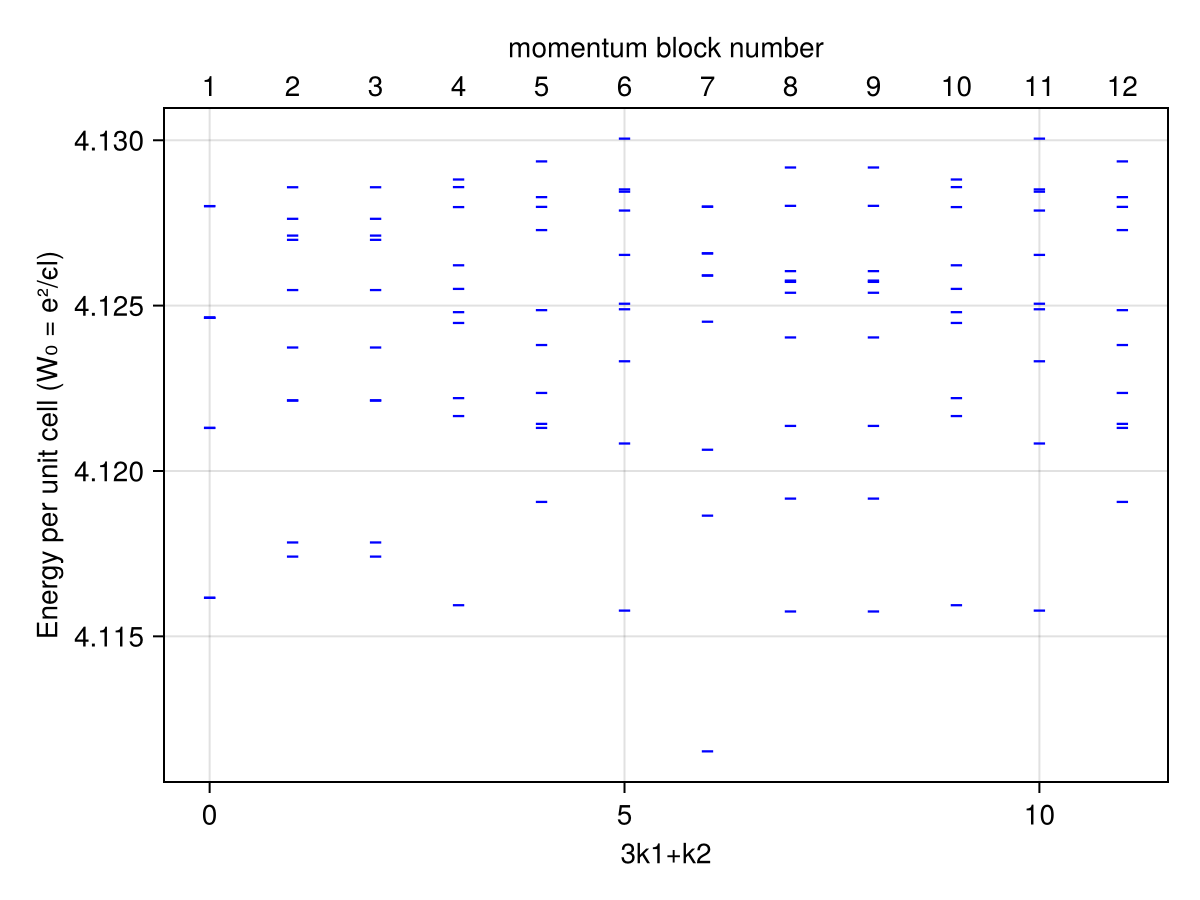

((energies[7])[1] / Nk) / LLT.W0 = 4.111521145483354
  0.406951 seconds (674.44 k allocations: 25.127 MiB, 10.05% compilation time)
maximum(abs.(imag.(str_fac210))) = 4.364678403798743e-18
extrema(real.(str_fac210)) = (-1.1842378929335004e-14, 2.2756671500056966)
str_fac210[index_shift..., 1, 2] = 2.2756671500056966 + 0.0im
str_fac210[index_shift..., 2, 1] = 1.6090004833390308 + 0.0im


1.6090004833390308 + 0.0im

In [57]:
plot_ed_spectrum() # 2, 10
@show energies[7][1]/Nk/LLT.W0
myvec210 = vectors[7][1]
@time str_fac210 = structure_factor_expectation(myvec210);
@show maximum(abs.(imag.(str_fac210)))
@show extrema(real.(str_fac210))
@show str_fac210[index_shift..., 1,2]
@show str_fac210[index_shift..., 2,1]

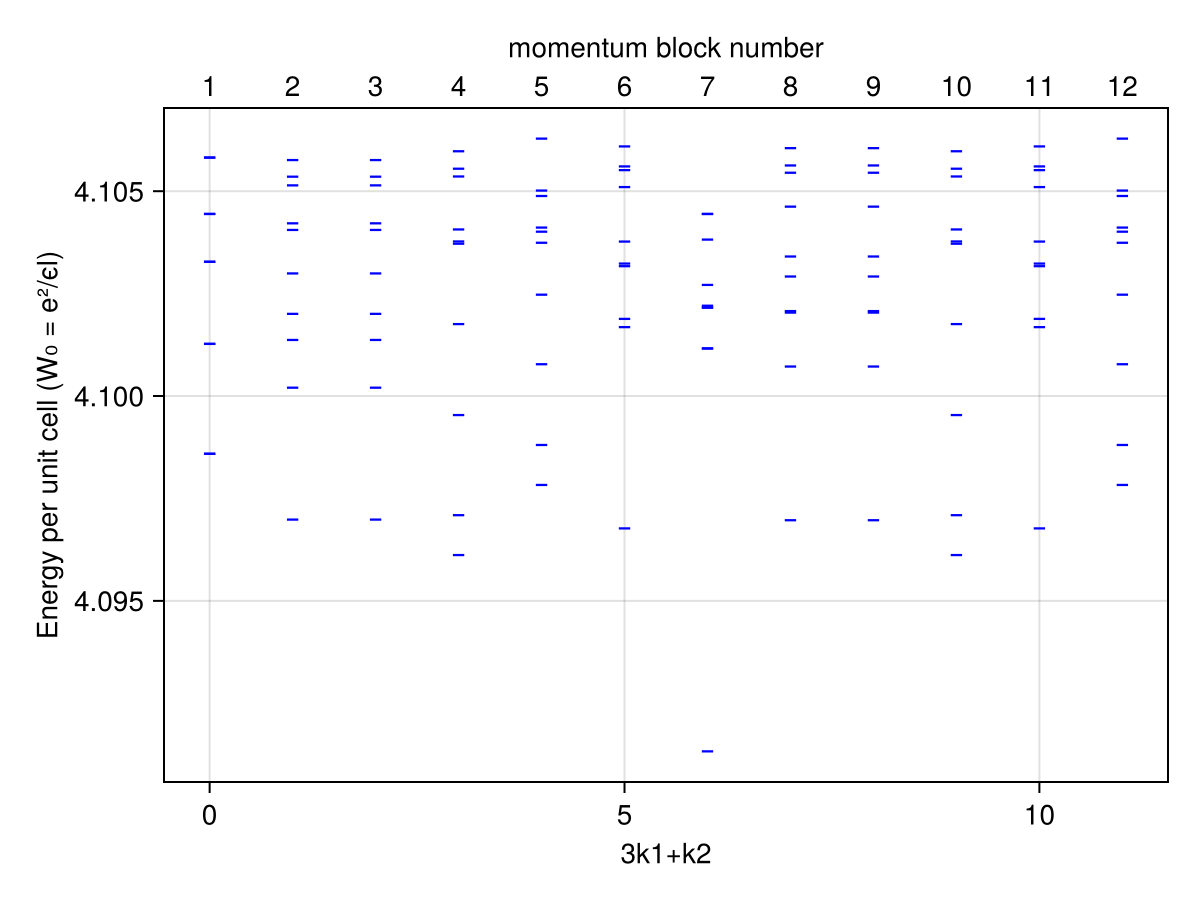

((energies[7])[1] / Nk) / LLT.W0 = 4.091325902581696
  4.473720 seconds (656.88 k allocations: 24.262 MiB)
maximum(abs.(imag.(str_fac39))) = 3.6061485276597165e-18
extrema(real.(str_fac39)) = (8.142215382591986e-21, 2.5626847557790526)
str_fac39[index_shift..., 1, 2] = 2.5626847557790526 + 0.0im
str_fac39[index_shift..., 2, 1] = 2.0626847557790535 + 0.0im


2.0626847557790535 + 0.0im

In [61]:
plot_ed_spectrum() # 3, 9
@show energies[7][1]/Nk/LLT.W0
myvec39 = vectors[7][1]
@time str_fac39 = structure_factor_expectation(myvec39);
@show maximum(abs.(imag.(str_fac39)))
@show extrema(real.(str_fac39))
@show str_fac39[index_shift..., 1,2]
@show str_fac39[index_shift..., 2,1]

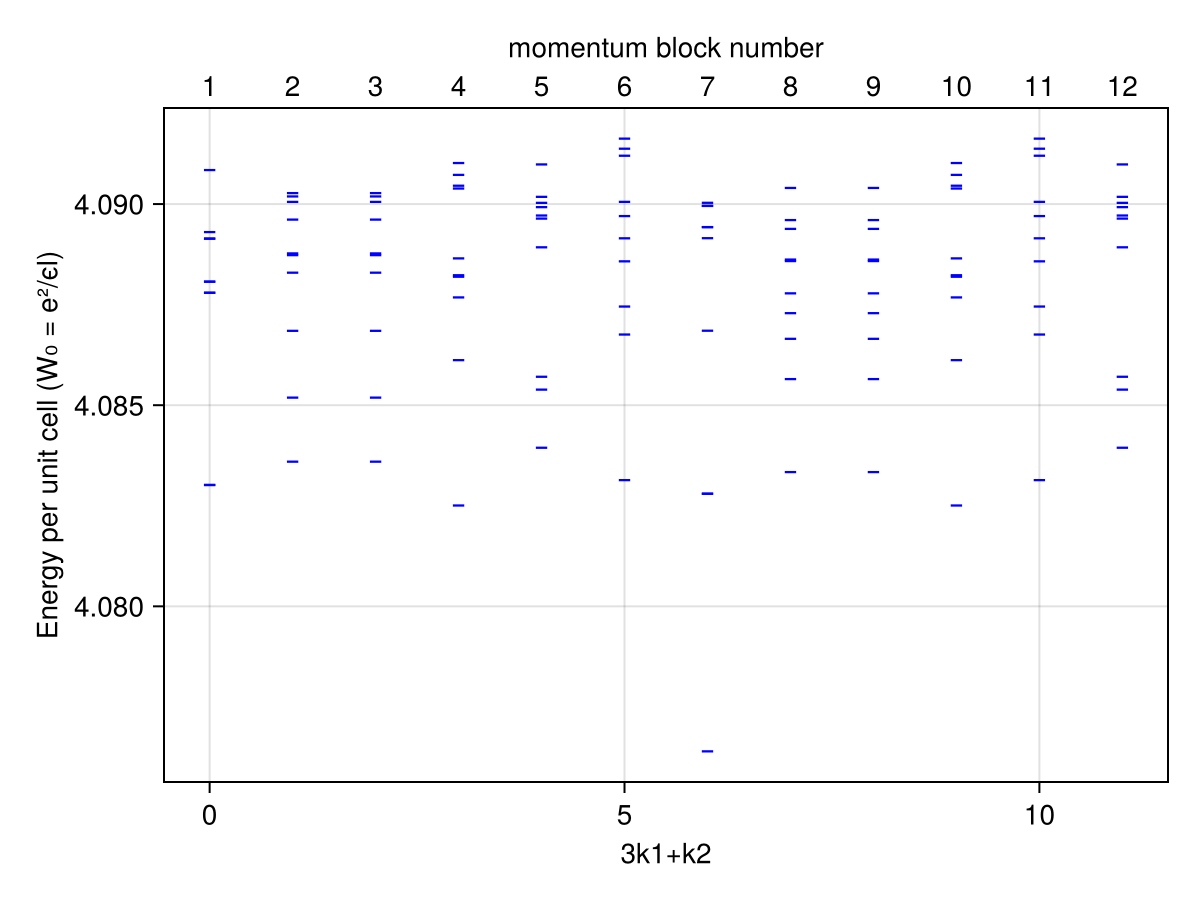

((energies[7])[1] / Nk) / LLT.W0 = 4.076393453244264
 23.367722 seconds (656.90 k allocations: 24.266 MiB, 0.06% gc time)
maximum(abs.(imag.(str_fac48))) = 2.4567377374380513e-18
extrema(real.(str_fac48)) = (1.5395184593617635e-20, 2.6524865024959916)
str_fac48[index_shift..., 1, 2] = 2.6524865024959916 + 0.0im
str_fac48[index_shift..., 2, 1] = 2.3191531691626603 + 0.0im


2.3191531691626603 + 0.0im

In [69]:
plot_ed_spectrum() # 4, 8
@show energies[7][1]/Nk/LLT.W0
myvec48 = vectors[7][1]
@time str_fac48 = structure_factor_expectation(myvec48);
@show maximum(abs.(imag.(str_fac48)))
@show extrema(real.(str_fac48))
@show str_fac48[index_shift..., 1,2]
@show str_fac48[index_shift..., 2,1]

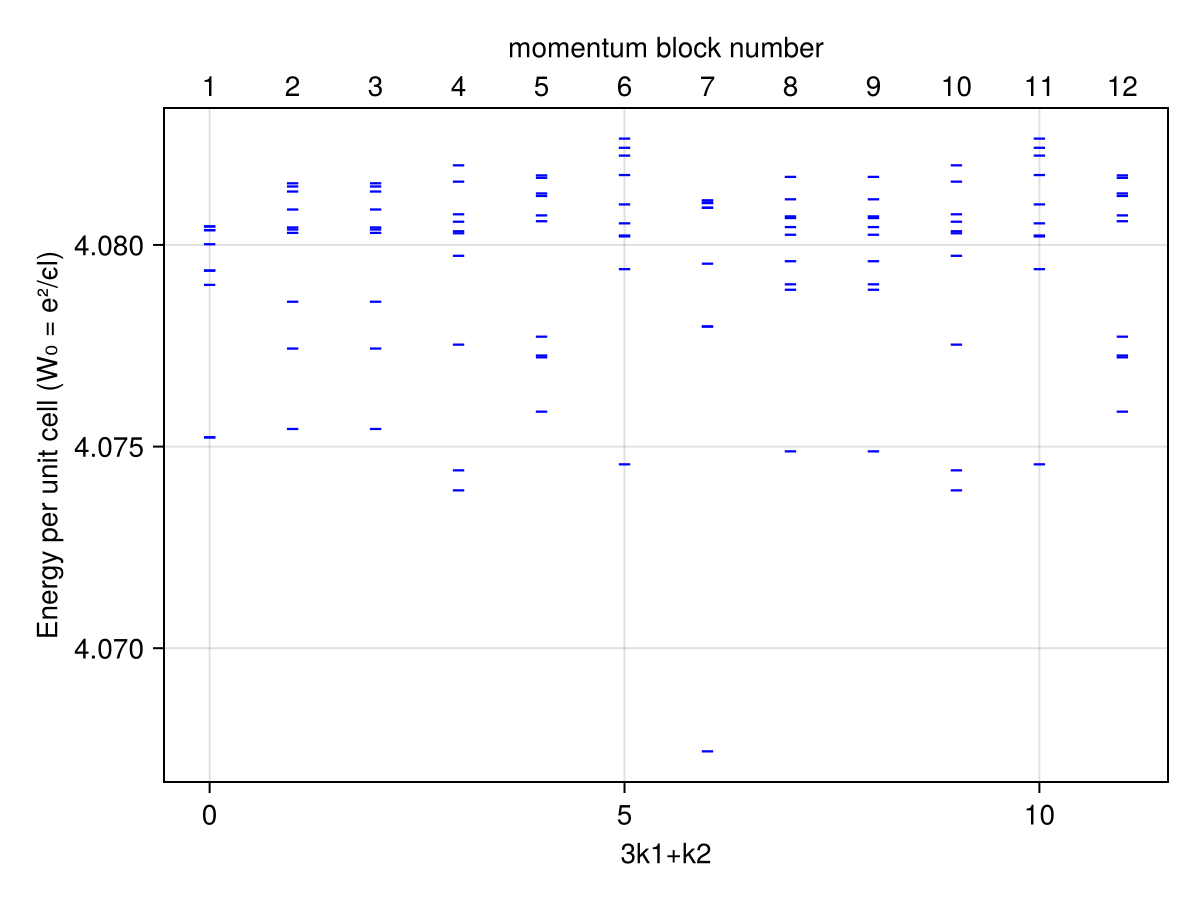

((energies[7])[1] / Nk) / LLT.W0 = 4.067442436801589
 62.659717 seconds (674.46 k allocations: 25.138 MiB, 0.06% compilation time)
maximum(abs.(imag.(str_fac57))) = 1.2197274440461925e-18
extrema(real.(str_fac57)) = (-1.5691152081368878e-13, 2.738436933823614)
str_fac57[index_shift..., 1, 2] = 2.738436933823614 + 0.0im
str_fac57[index_shift..., 2, 1] = 2.5717702671569445 + 0.0im


2.5717702671569445 + 0.0im

In [76]:
plot_ed_spectrum() # 5, 7
@show energies[7][1]/Nk/LLT.W0
myvec57 = vectors[7][1]
@time str_fac57 = structure_factor_expectation(myvec57);
@show maximum(abs.(imag.(str_fac57)))
@show extrema(real.(str_fac57))
@show str_fac57[index_shift..., 1,2]
@show str_fac57[index_shift..., 2,1]

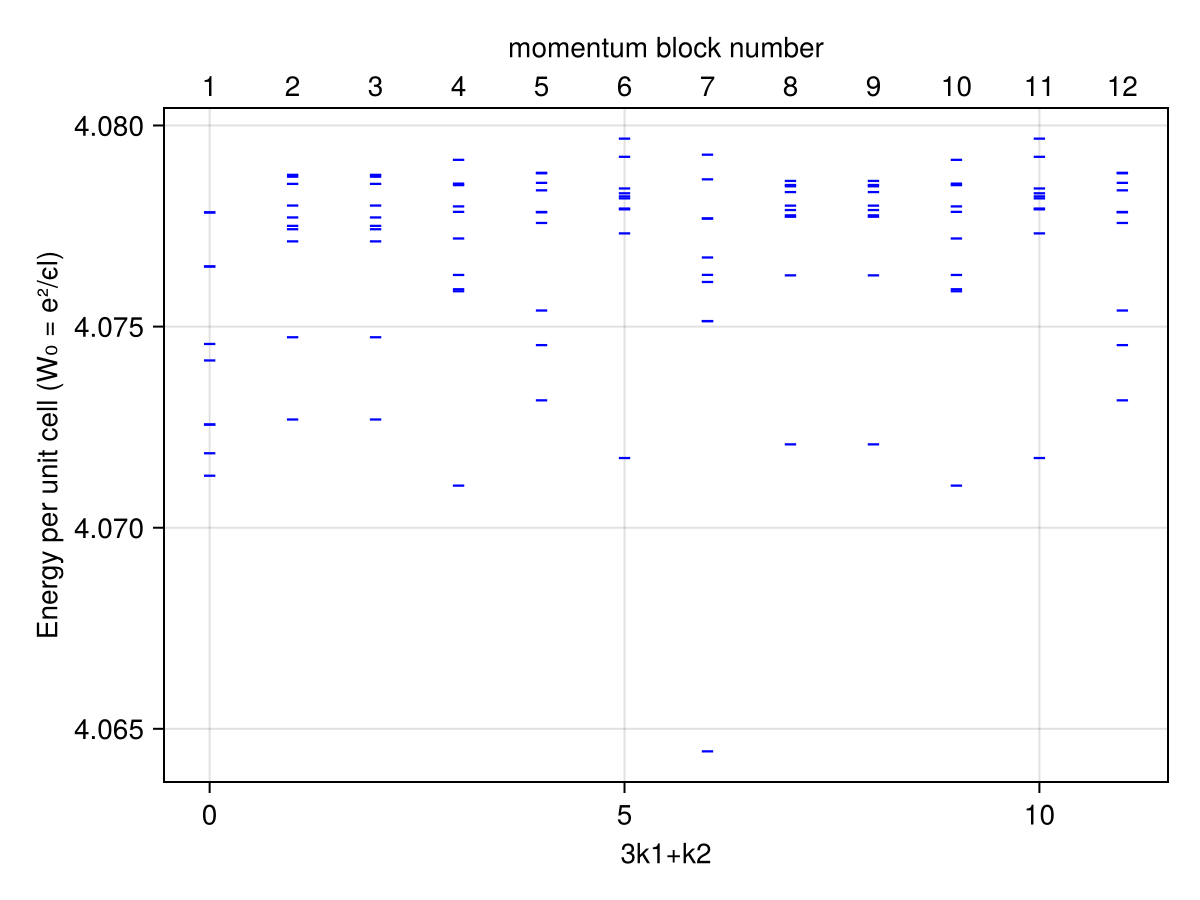

((energies[7])[1] / Nk) / LLT.W0 = 4.064439816825849
 77.075040 seconds (674.48 k allocations: 25.144 MiB, 0.05% compilation time)
maximum(abs.(imag.(str_fac66))) = 2.2708065507675393e-18
extrema(real.(str_fac66)) = (3.010800956256277e-20, 2.7057576385750917)
str_fac66[index_shift..., 1, 2] = 2.7057576385750917 + 0.0im
str_fac66[index_shift..., 2, 1] = 2.7057576385750903 + 0.0im


2.7057576385750903 + 0.0im

In [84]:
plot_ed_spectrum() # 6, 6
@show energies[7][1]/Nk/LLT.W0
myvec66 = vectors[7][1]
@time str_fac66 = structure_factor_expectation(myvec66);
@show maximum(abs.(imag.(str_fac66)))
@show extrema(real.(str_fac66))
@show str_fac66[index_shift..., 1,2]
@show str_fac66[index_shift..., 2,1]

In [ ]:
let structure_factor = str_fac66
    layer = (2,1)
    fig = Figure();
    ax = Axis(fig[1,1])
    hm = heatmap!(ax, (-2Gk[1]:2Gk[1])./Gk[1], (-2Gk[2]:2Gk[2])./Gk[2], 
        real.(structure_factor[:,:,layer...]);
        colorrange = (0.0, maximum(real.(structure_factor[:,:,layer...]))),
        colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
    )
    Colorbar(fig[1, 2], hm)
    display(fig)
end

In [11]:
# check energies explicitly to see degeneracy.

bn = 7 # the block number to inspect
println("total momentum: ", block_k1[bn], "  ", block_k2[bn])
energies[bn]/Nk/LLT.W0

total momentum: 2  0


10-element Vector{Float64}:
 4.175984489874237
 4.196802243280028
 4.205105346400772
 4.20880004431514
 4.208800044315151
 4.212177344969166
 4.212824910443111
 4.212824910443121
 4.2160666411923815
 4.216066641192382

In [10]:
# twist angle path for the Wilson loop integral
N_shift = 10  # number of shifts along each edge
path = Tuple{Float64, Float64}[(0.0, 0.0)]
push!(path, (1/N_shift, 0.0))
push!(path, (1/N_shift, 1/N_shift))
push!(path, (0.0, 1/N_shift))
push!(path, (0.0, 0.0))
path

5-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (0.1, 0.0)
 (0.1, 0.1)
 (0.0, 0.1)
 (0.0, 0.0)

In [11]:
bn =  7                    # block number
nstates = 1                # number of degenerating states

psi_before = reduce(hcat, vectors[bn][1:nstates])
ED_connection_gaugefixing!(psi_before, [300])  # fix global phase
psi_after = similar(psi_before)

WilsonLoopIntegral= Vector{Float64}(undef, 4)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    scat_list = ED_sortedScatterList_twobody(para_conserve; kshift = path[i+1]);
    vecs = EDsolve(blocks[bn], scat_list; N = 6,
        showtime = false,
    )[2][1:nstates]
    psi_after .= reduce(hcat, vecs)
    ED_connection_gaugefixing!(psi_after, [300])  # fix global phase

    WilsonLoopIntegral[i] = ED_connection_step(blocks[bn], 
        psi_after, psi_before, path[i+1], path[i], para_conserve;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before .= psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π) * N_shift^2


path point #1 	 (0.1, 0.0)
Inner product: amp = 1.0000000000000007, phase = -0.31415926533602223
path point #2 	 (0.1, 0.1)
Inner product: amp = 1.000000000000008, phase = 0.5026548245923186
path point #3 	 (0.0, 0.1)
Inner product: amp = 0.9999999999999949, phase = 0.3455751918820462
path point #4 	 (0.0, 0.0)
Inner product: amp = 0.9999999999999943, phase = -0.471238898046005


1.0000000003269316